@misc{multiobjectdatasets19,
  title={Multi-Object Datasets},
  author={Kabra, Rishabh and Burgess, Chris and Matthey, Loic and
          Kaufman, Raphael Lopez and Greff, Klaus and Reynolds, Malcolm and
          Lerchner, Alexander},
  howpublished={https://github.com/deepmind/multi-object-datasets/},
  year={2019}
}

1. In ce format se gaseste: TFRecords
2. Cate imagini contine: 100000
3. Cate tipuri de obiecte contine: 3
4. Numarul de obiecte este intre 1-11

In [ ]:
pip install torch wget pandas torchviz matplotlib numpy scipy tensorflow

In [11]:
!wget -P ./data/input https://storage.googleapis.com/multi-object-datasets/clevr_with_masks/clevr_with_masks_train.tfrecords

In [3]:
import os
import torch
import torchviz
import numpy as np
import pandas as pd
from torch import nn
import tensorflow as tf
from typing import Iterator
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

if environment == 'Jupyter':
    from multi_object_datasets import clevr_with_masks
elif environment == 'Colab':
    import clevr_with_masks

In [73]:
class Args():
    def __init__(self):
        # Config elements
        self.batch_size = 64
        self.test_batch_size = 64
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.9
        self.seed = 1
        self.log_interval = int(10_000 / self.batch_size)
        self.max_img_count = 100_000
        self.environment = 'Jupyter' # 'Colab' or 'Jupyter'
        self.shuffle = False
        self.shuffle_buffer_size = 100

# Instantiate a configuration
args = Args()

# Use device config
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [74]:
from torch.utils.data import IterableDataset

class SegmentationDataset(IterableDataset):
  def _download_dataset(self):
    # Check if the input data already exists
    if not os.path.exists(self._input_file):
      # Download the samples
      !wget -P ./data/input https://storage.googleapis.com/multi-object-datasets/clevr_with_masks/clevr_with_masks_train.tfrecords

  def __init__(self, first_k=args.max_img_count, shuffle=args.shuffle, seed=args.seed):
    # Define input paths
    self._input_dir = './data/input'
    self._input_filename = 'clevr_with_masks_train.tfrecords'
    self._input_file = f'{self._input_dir}/{self._input_filename}'

    # Download the dataset if it isn't already present
    self._download_dataset()

    # Lazily load the dataset initially using Tensorflow 
    self._tf_dataset = clevr_with_masks.dataset(self._input_file)
    self._first_k=first_k

    # Shuffle the dataset if necessary
    if shuffle:
      self._tf_dataset = self._tf_dataset.shuffle(args.shuffle_buffer_size, seed)

  def _tf2pt(self, dataset: tf.data.Dataset):
    for idx, entry in enumerate(dataset):
      # Stop the iteration 
      if idx == self._first_k:
        return
      image = torch.from_numpy(entry['image'].numpy())
      mask = torch.from_numpy(entry['mask'].numpy())
      yield image, mask

  def __iter__(self):
    return self._tf2pt(self._tf_dataset)

In [75]:
dataset = SegmentationDataset(20)

In [76]:
from torch.utils.data import SequentialSampler

dataloader = DataLoader(dataset, batch_size)

C:\Users\invokariman\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


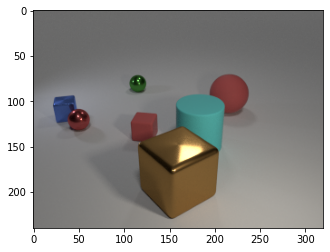

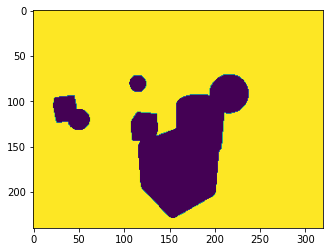

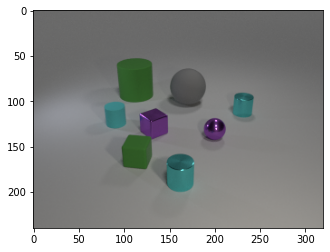

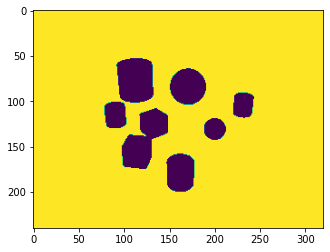

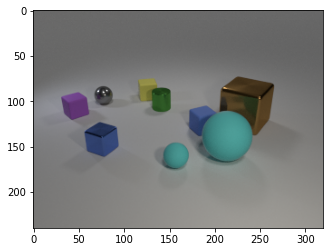

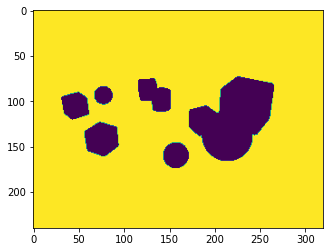

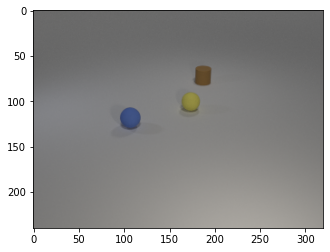

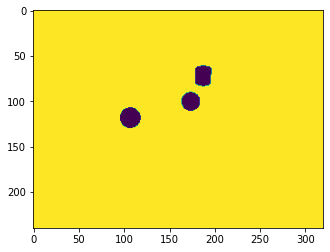

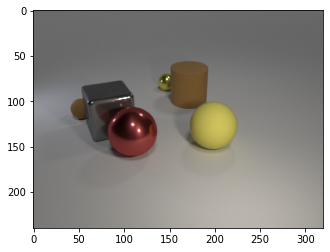

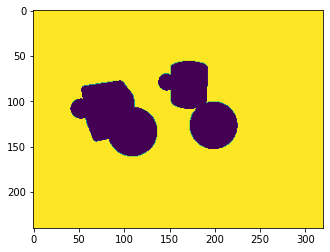

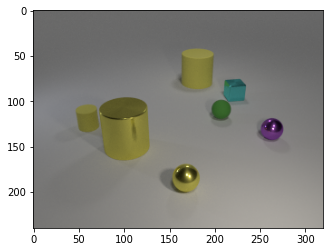

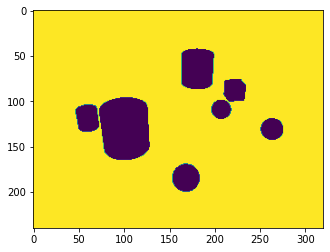

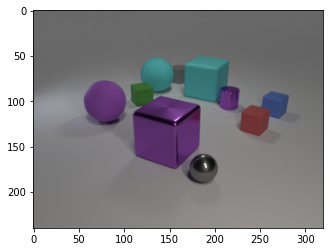

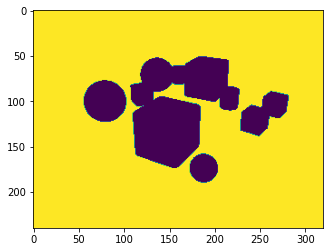

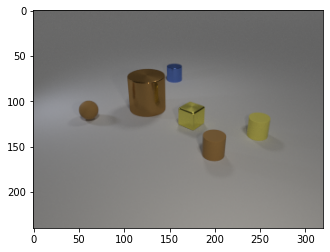

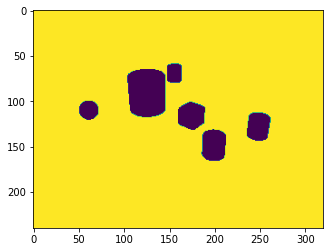

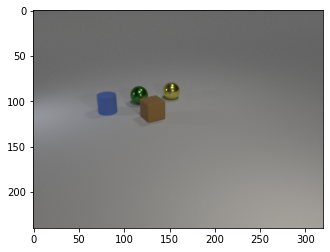

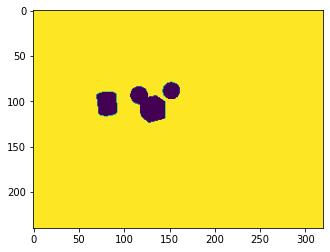

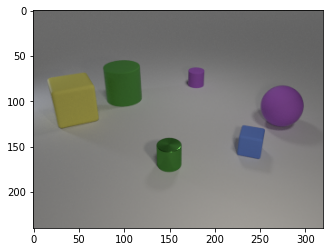

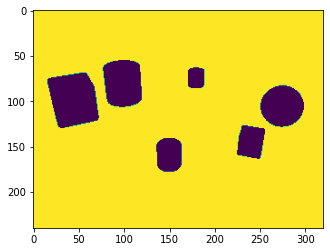

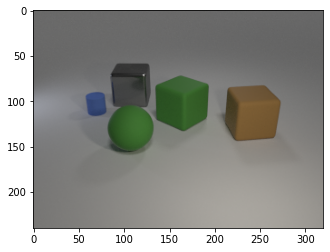

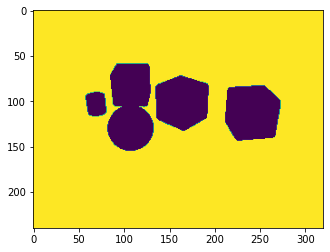

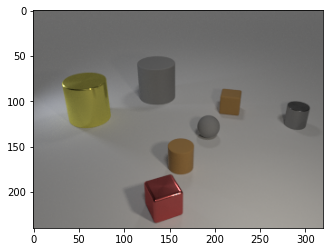

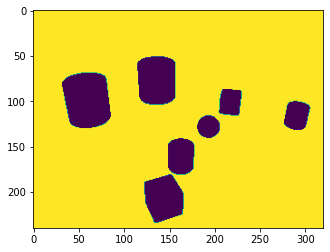

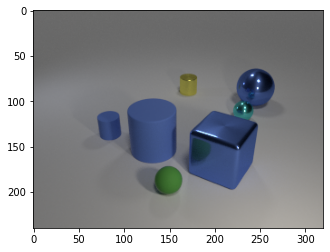

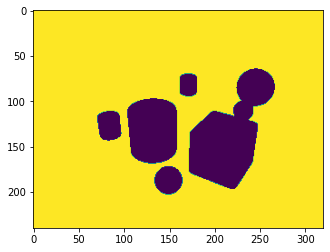

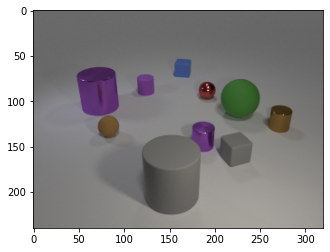

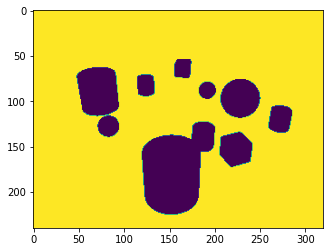

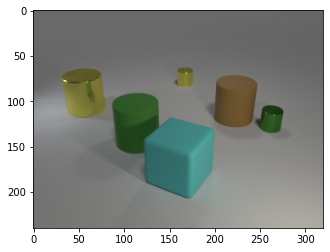

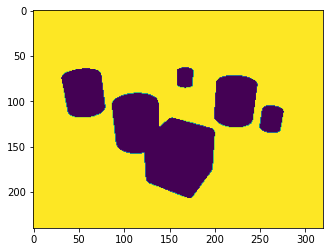

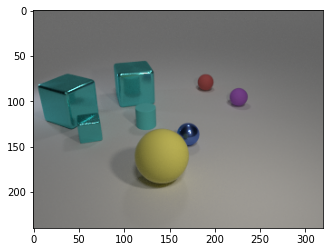

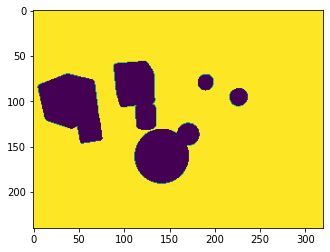

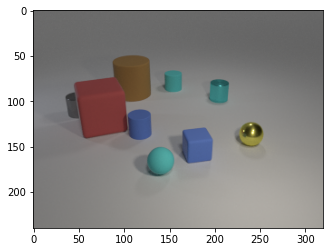

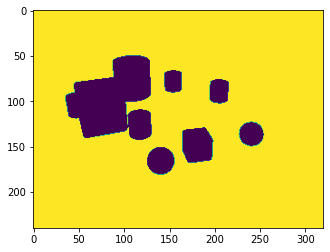

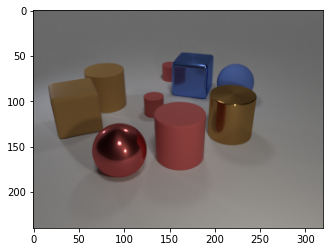

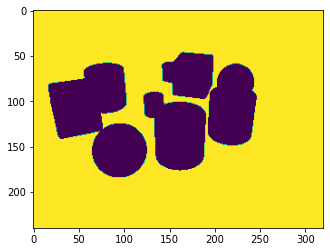

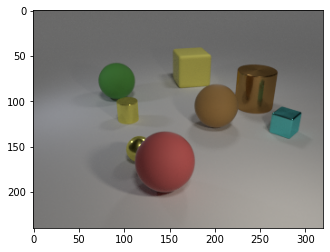

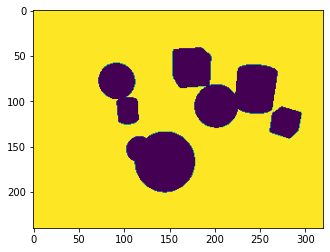

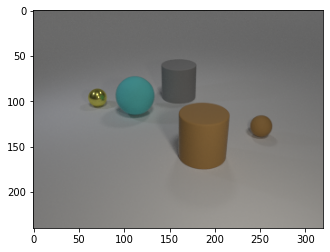

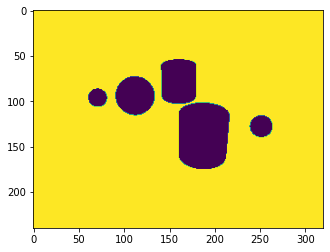

In [77]:
for batch in dataloader:
    images, masks = batch
    for i in range(images.shape[0]):
        plt.figure()
        plt.imshow(images[i])
        plt.figure()
        plt.imshow(masks[i][0])
    break